In [1]:
## Updated 1-7-25


import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import random
from joblib import load
import time
import unsupervised_scripts


## Sample Directory (different for everyone)
data_dir = (input('Enter the path to your .tif hyperstacks: ').strip() or os.getcwd())


## Load Image
from tkinter import*
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

from tkinter import filedialog
sample = filedialog.askopenfilename(initialdir=data_dir, multiple=True)
image = io.imread(sample[0])

indeces = [index for index, char in enumerate(sample[0]) if char=='/']
sample_name = sample[0][indeces[-1]+1:]

save_dir = 'D:/Shi_Lab/Spectral_Clustering/ML/output/'+sample_name+'/'
if os.path.exists(save_dir) == False:
  os.mkdir(save_dir)

## Remove NaNs and inf
image[np.isinf(image)] = 0
image[np.isnan(image)] = 0

## Vectorize Image
image_vec = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]))
image_vec = image_vec.T

## Initialize start and end of hyperspectral sweep; num_samp is calculated from image stack
wavenum_1 = int(input('Enter first wavenumber/higher wavelength (Default=2700)): ').strip() or '2700')
wavenum_2 = int(input('Enter last wavenumber/lower wavelength (Default=3100): ').strip() or '3100')
num_samp = int(image_vec.shape[1])
ch_start = int(np.floor(num_samp/((wavenum_2-wavenum_1)/(2800-wavenum_1))))
background_df = pd.read_csv('water_HSI_76.csv')
molecule_df = pd.read_excel('lipid_subtype.xlsx')

### Semi-Supervised Learning

## Load artificial dataset
artificial_data = unsupervised_scripts.artificial_dataset(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
[mol_norm, mol_names] = artificial_data.molecule_dataset(molecule_df)

X_data = np.load('artificial_data/artificial_training_data-'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.npy')
Y_data = np.tile(np.array(range(mol_names.shape[0])), (X_data.shape[0], 1))
X = np.reshape(X_data, (X_data.shape[0] * X_data.shape[1], X_data.shape[2]))
Y = np.reshape(Y_data, (Y_data.shape[0] * Y_data.shape[1]))

## Process both datasets
preprocessing = unsupervised_scripts.preprocessing(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
X_norm  = preprocessing.spectral_standardization(np.flip(X,axis=1))
image_norm = preprocessing.spectral_standardization(np.flip(image_vec,axis=1), br_shift=0)


(array([ 6050., 20520., 30060., 22470., 18960., 15400., 10000.,  4750.,
         1310.,   480.]),
 array([0.        , 0.11254491, 0.22508982, 0.33763473, 0.45017963,
        0.56272454, 0.67526945, 0.78781436, 0.90035927, 1.01290418,
        1.12544909]),
 <BarContainer object of 10 artists>)

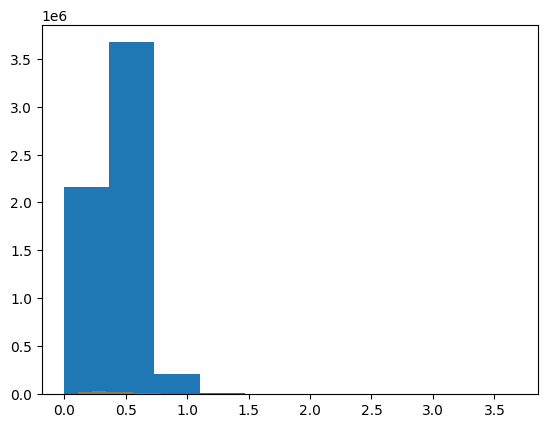

In [2]:
plt.hist(np.max(image_norm,axis=1)-image_norm[:,0])
plt.hist(np.max(X_norm,axis=1)-X_norm[:,0],alpha=0.5)

In [11]:
np.argmin(image_norm,axis=0)

array([1850859, 1848399, 5370491, 5827831, 5425538,  623122,  615749,
        627043, 1750444, 5427996, 1484097, 1750445, 4999038, 1750444,
       1750444, 1750445, 1750445, 1750445, 1750445, 5817995, 1750445,
       4999038, 4999037, 5820458, 3933969, 1845941, 1845941, 3933968,
       5001496, 1845941,  640348, 1845941,  640348,  640348,  640347,
        640348,  642807,  640347,  637888,  640347, 1782422,  642807,
        637888,  637885, 1784881, 1827523,  635422,  637884,  630502,
       5429965, 1850859], dtype=int64)

In [20]:
np.median(image_norm[:,:ch_start])

0.0

In [6]:
## Save Normalized Image and channels

norm_image = np.reshape(image_norm, (image.shape[1],image.shape[2],image.shape[0]))
norm_image = np.moveaxis(norm_image, 2, 0)
io.imsave(save_dir+'normalized-'+sample_name, norm_image.astype('float32'))
io.imsave(save_dir+'normalized-unsat-'+sample_name, np.max(norm_image[-13:-10],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-protein-'+sample_name, np.max(norm_image[-22:-19],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-sat-'+sample_name, np.max(norm_image[-28:-25],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-lipid-'+sample_name, np.max(norm_image[-33:-30],axis=0).astype('float32'))

Text(0, 0.5, 'Normalized Intensity (A.U.)')

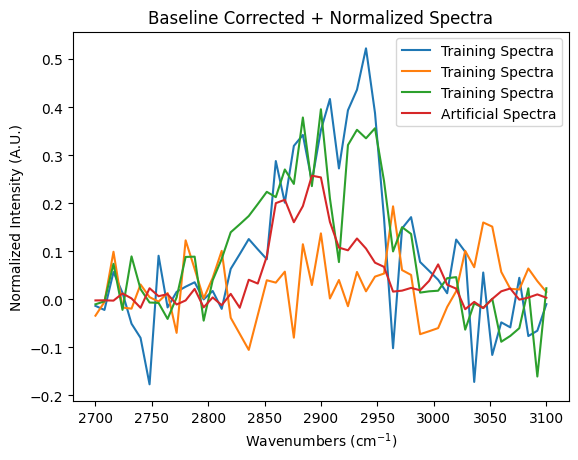

In [13]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
indeces = [random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1)]
plt.plot(wavenumbers, image_norm[indeces].T, label = 'Training Spectra')
plt.plot(wavenumbers, X_norm[np.random.randint(0,X_norm.shape[0])].T, label = 'Artificial Spectra')
plt.legend()
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

In [ ]:
# ## Optimize Smoothing of HSI and artificial spectra
# w = int(input('Enter window size for Savitzky-Golay smoothing (Default=6): ').strip() or '6')
# p = int(input('Enter polynomial for Savitzky-Golay smoothing (Default=3): ').strip() or '3')
# preprocessing.sav_gol_optimization(image_norm, w, p)
# preprocessing.sav_gol_optimization(X_norm, w, p)
# x = savgol_filter(image_norm,w,p, axis=1, mode='mirror')
# X = savgol_filter(X_norm,w,p, axis=1, mode='mirror')
# smooth = 'smoothing-'+str(w)+'-'+str(p)

In [30]:
## No smoothing (OPTIONAL)
x = image_norm
X = X_norm

smooth = 'No Smoothing'

In [ ]:
## Random Forest Classification
rf_classifier = unsupervised_scripts.RF_classify(x, X, Y, .25)
rfc = load('rf_classifiers/rfc-'+smooth+'_'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.joblib')
print('Accuracy Score: ' + str(rfc.score(rf_classifier.X_train, rf_classifier.y_train)))
rf_classifier.confusion_matrix(mol_names, rfc)

In [ ]:
## USe Random Forest Classifier on Unlabeled HSI
start_time = time.time()
outputs = unsupervised_scripts.semi_supervised_outputs(x, mol_names, rfc)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [ ]:
## Spectral Graphs
print('Save spectral graphs?')
# save_input = helper_scripts.save_input()
save_input = True
outputs.spectral_graphs(mol_norm, wavenumbers, save_input, save_dir)
outputs.probability_images(image, save_input, save_dir)

In [34]:
# print('Save similarity metric .csv?')
# save_input = helper_scripts.save_input()
# outputs.similarity_metrics(mol_norm, save_input, save_dir)